# Personalizing news content using Contextual Bandits

In the [Contextual Bandit(CB) introduction tutorial](https://vowpalwabbit.github.io/guides/contextual_bandits.html), we learnt about CB and different CB algorithms. In this tutorial we will simulate the scenario of personalizing news content on a site, using CB, to users. The goal is to maximize user engagement quantified by measuring click through rate (ctr).

Let's recall that a CB setting has four components: 

- Context
- Action
- Probability of choosing action
- Reward/cost for chosen action

We want to maximize reward (ctr) or minimize loss (-ctr)

- We have two website visitors: 'Tom' and 'Anna'
- They visit the website at two different times in a day: 'morning' and 'afternoon'

The **context** is therefore (user, time_of_day)

We have the option of recommending a variety of articles to Tom and Anna. Therefore, **actions** are the different choices of articles: "politics", "sports", "music", "food", "finance", "health", "cheese"

The **reward** is whether they click on the article or not: 'click' or 'no click'

In the real world, we will have to learn Tom and Anna's preferences for articles i.e. the "cost function". Since this is a simulation we will define a cost function and see if the learner can optimize towards the cost function as we see more samples.

We will also modify the cost function in a few different ways and see if the CB learner picks up the changes. We will compare the CTR with and without learning.

Let's first start with importing the necessary packages:

In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

# Reward function

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

The reward function below specifies that Tom likes politics in the morning and music in the afternoon whereas Anna likes sports in the morning and politics in the afternoon. It looks dense but we are just simulating our hypothetical world in the format of the feedback the learner understands: cost. If the learner recommends an article that aligns with the reward function, we give a positive reward. In our simulated world this is a click.

In [3]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

# Understanding VW format

There are some things we need to do to get our input into a format VW understands. This function handles converting from our context as a dictionary, list of articles and the cost if there is one into the text format VW understands. 

In [4]:
# This function modifies (context, action, cost, probablity) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

To understand what's going on here let's go through an example. Here, it's the morning and the user is Tom. There are four possible articles. So in the VW format there is one line that starts with shared, this is the shared context, followed by four lines each corresponding to an article.

In [5]:
context = {"user":"Tom","time_of_day":"morning"}
actions = ["politics", "sports", "music", "food"]

print(to_vw_example_format(context,actions))

shared |User user=Tom time_of_day=morning
|Action article=politics 
|Action article=sports 
|Action article=music 
|Action article=food 


# Getting an article/action recommendation

When we call VW we get a _pmf_, or probability mass function, as the output. Since we are incorporating exploration into our strategy VW is giving us a list of probabilities of choosing each option. Our job here is to simply sample this list based on the probabilities.

So, given a list `[0.7, 0.1, 0.1, 0.1]`, we would choose the first item with a 70% chance. `sample_custom_pmf` takes such a list and gives us the index it chose and what the probability of choosing that index was.

In [6]:
# This function .....
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

Now we can actually get a prediction from VW!

1. We convert our context and actions into the text format we need
2. We pass this example to vw and get the pmf out
3. Now, we sample this pmf to get what article we will end up showing
4. Finally we return the article chosen, and the probability of choosing it (we are going to need the probability when we learn form this example)

In [7]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

# Simulation set up

Now that we have done all of the setup work and know how to interface with VW, let's simulate the world of Tom and Anna. The scenario is they go to a website and are shown an article. Remember that the reward function allows us to define the worlds reaction to what VW recommends.


We will choose between Tom and Anna uniformly at random and also choose their time of visit uniformly at random. You can think of this as us tossing a coin to choose between Tom and Anna (Anna if heads and Tom if tails) and another coin toss for choosing time of day.

In [8]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

We will initialize the CB learner in VW and then simulate their website visits `num_iterations` number of times. In each visit, we:

1. Decide between Tom and Anna
2. Decide time of day
3. Pass context i.e. (user, time of day) to learner to get action i.e. article recommendation and probability of choosing action
4. Receive reward i.e. see if user clicked or not. Remember that cost is just negative reward.
5. Format context, action, probablity, reward in VW format
6. Learn from the example

This is the same for every one of our simulations, so we define the process in the `run_simulation` function. The cost function must be supplied as this is essentially us simulating how the world works.

In [9]:
def run_simulation(vw, num_iterations, users, times_of_day, actions, cost_function, should_learn = True):
    cost_sum = 0.
    ctr = []
    
    for i in range(1, num_iterations+1):
        # 1. In each simulation choose a user 
        user = choose_user(users) 
        # 2. Choose time of day for a given user
        time_of_day = choose_time_of_day(times_of_day)

        # 3. Pass context to vw to get an action 
        context = {'user': user, 'time_of_day': time_of_day}
        action, prob = get_action(vw, context, actions)
        
        # 4. Get cost of the action we chose
        cost = cost_function(context, action)
        cost_sum += cost
        
        if should_learn:
            # 5. Inform VW of what happened so we can learn from it
            vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
            # 6. Learn
            vw.learn(vw_format)
        
        # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
        ctr.append(-1*cost_sum/i)
        
    return ctr

We want to be able to visualize what is occuring, so we are going to plot the click through rate over each iteration of the simulation. If VW is showing actions the get rewards the ctr will be higher. Below is a little utility function to make showing the plot easier.

In [10]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# Scenario 1

We will use the first reward function `get_cost` and assume that Tom and Anna do not change their preferences over time and see what happens to user engagement as we learn.

#### With learning

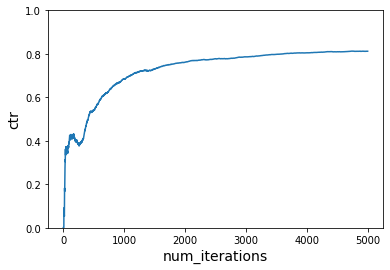

In [11]:
# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

##### Aside: interactions
You'll notice in the arguments we supply to VW, we include `-q UA`. This is telling VW to create new features which are the features in the (U)ser namespace and (A)ction namespaces multiplied together. This allows us to learn the interaction between when certain actions are good in certain times of days and for particular users. If we didn't do that, the learning wouldn't really work. We can see that in action below.

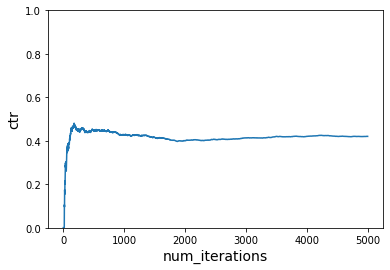

In [20]:
# Initialize learner in VW but without -q
vw = pyvw.vw("--cb_explore_adf --quiet --epsilon 0.2")

num_iterations = 5000
ctr = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost)

plot_ctr(num_iterations, ctr)

#### Without learning
Let's do the same thing again (but with `-q`, but this time show the effect if we don't learn from what happens. The ctr never improves are we just hover around 0.2.

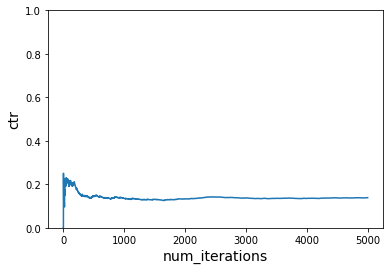

In [12]:
# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations = 5000
ctr  = run_simulation(vw, num_iterations, users, times_of_day, actions, get_cost, should_learn=False)

plot_ctr(num_iterations, ctr)

# Scenario 2

In the real world people's preferences change over time. So now in the simulation we are going to incorporate two different cost functions, and swap over to the second one halfway through. Below is a a table of the new reward function we are going to use, `get_cost_1`:

### Tom
| | `get_cost` | `get_cost_new1` | 
|---|---|---|
| **Morning** | Politics | Politics | 
| **Afternoon** | Music | Sports | 

### Anna
| | `get_cost` | `get_cost_new1`  |
|---|---|---|
| **Morning** | Sports | Sports |
| **Afternoon** | Politics | Sports |

This reward function is still working with actions that the learner has seen previously.

In [13]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

To make it easy to show the effect of the cost function changing we are going to modify the `run_simulation` function. It is a little less readable now, but it supports accepting a list of cost functions and it will operate over each cost function in turn. This is perfect for what we need.

In [14]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, should_learn = True):
    cost_sum = 0.
    ctr = []
    
    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user 
            user = choose_user(users) 
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if should_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations
        
    return ctr

#### With learning
Let us now switch to the second reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the web users but it is still working with the same action space as before. We should see the learner pick up these changes and optimize towards the new preferences.

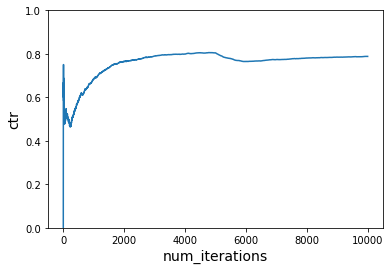

In [15]:
# use first reward function initially and then switch to second reward function

# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Without learning

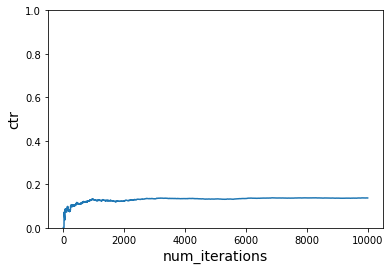

In [16]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, should_learn=False)
plot_ctr(total_iterations, ctr)

# Scenario 3
In this scenario we are going to start rewarding actions that have never seen a reward previously when we change the cost function. 

### Tom
| | `get_cost` | `get_cost_new2` |
|---|---|---|
| **Morning** | Politics |  Politics|
| **Afternoon** | Music |   Food |

### Anna
| | `get_cost` | `get_cost_new2` |
|---|---|---|
| **Morning** | Sports | Food|
| **Afternoon** | Politics |  Food |

In [17]:
def get_cost_new2(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'food':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'food':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

#### With learning
Let us now switch to the third reward function after a few samples (running the first reward function). Recall that this reward function changes the preferences of the users and is working with a **different** action space than before. We should see the learner pick up these changes and optimize towards the new preferences

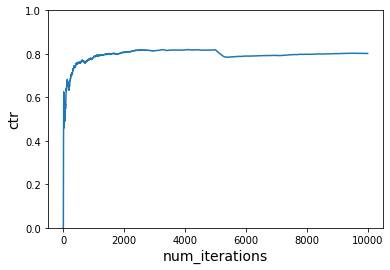

In [18]:
# use first reward function initially and then switch to third reward function

# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Without Learning

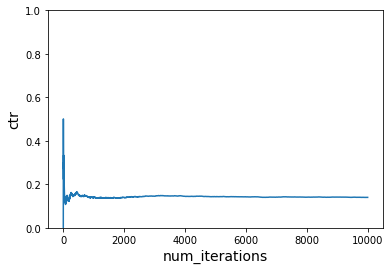

In [19]:
# Do not learn
# use first reward function initially and then switch to third reward function

# Initialize learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, should_learn=False)

plot_ctr(total_iterations, ctr)

# Summary

This tutorial aimed ad showcasing a real world scenario that contextual bandits can be applied to. We were able to take a context and list of actions and learn what actions worked best for which context. We saw that the learner was able to respond rapidly to changes in the world. As a baseline we showed the case without learning to prove we completely outperform it.

In [ ]:
# things to do
# (1) change reward function and see how learning happens - DONE (PAVITHRA)
# (2) polish content - good story telling - IN PROGRESS (PAVITHRA)
# (3) add comments - IN PROGRESS (PAVITHRA)
# (4) add plots to see how rewards change per action over time THINKING THROUGH THIS (PAVITHRA)
# (5) Scenario 4: add some noise to reward function
# (6) explain VW example format - DONE (Jack)
# (7) label plots properly = DONE (Jack)
# (8) Summarize results and wrap up story